<a href="https://colab.research.google.com/github/JonDee2023/VehicleInsuranceClaims/blob/main/ModelingVehicleInsuranceClaims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project Description

This project work attempts to model Car Insurance Claims data in order to predict successful car insurance
claims against unsuccessful (or fraudulent) claims. The dataset is a privately sourced one belonging to XYZ
insurance company.
The procedures include: data preparation--- cleaning, exploration to determine unique properties, and treatment
for modeling purpose, model development, evaluation and testing, and communication of results.

#### Objectives
1.	Identify the demographic and behavioral factors that significantly influence the likelihood of filing an insurance claim. This can include analyzing how age, gender, driving experience, and past driving violations (like speeding or DUIs) correlate with claim frequency.
2.	Explore the relationship between credit scores and insurance claims to determine if there is a predictive link between financial   responsibility and driving behavior.
3.	Assess how vehicle ownership, vehicle age, and type influence the likelihood of claims. This may help in understanding whether newer or older vehicles are more prone to accidents or claims.
4.	Analyze the direct impact of driving behaviors, such as annual mileage and the number of speeding violations, on the outcome of insurance claims.

### Step 1: Data Preparation

Load and clean data

In [3]:
! pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.6 MB/s eta 0:00:00


In [4]:
# Import required Python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway # for performing ANOVA
from scipy.stats import pointbiserialr
from math import sqrt
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve
import pickle

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Car_Insurance_Claim.csv to Car_Insurance_Claim.csv


In [5]:
# Load data into pandas
filepath = "Car_Insurance_Claim.csv"
df = pd.read_csv(filepath)

# Preview the data
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [6]:
# Check data size
print(df.shape)

# Check data properties
df.info()

(10000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  1000

In [7]:
# Treat null values

for col in df.columns:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(0)

# Treat mislabeled data: Change data type of VEHICLE_OWNERSHIP, MARRIED, CHILDREN, OUTCOME
# from float to integer.

false_float = ['VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'OUTCOME']
for item in false_float:
    df[item] = df[item].astype(int)


### Step 2: Independent Analysis

#### A.
__Examine how insurance claims are distributed based on the various demographic factors captured in the data.__

In [8]:
# Create a list of demographic factors
demography = ['AGE', 'GENDER', 'RACE', 'EDUCATION', 'INCOME', 'MARRIED', 'CHILDREN', 'VEHICLE_OWNERSHIP']

In [20]:
def demography_claims_visualizer(factor):
    """Function """
    df_factor = (df.groupby(factor)['OUTCOME'].count()
            .rename('num_claims')
            .to_frame()
                 )

    print(df_factor)

    # Visualize the result
    df_factor.plot(kind='bar', xlabel=factor, ylabel='Number of Claims',
            title=f'Car Insurance Claims by {factor}s'
                  )

    plt.xticks(rotation=0)
    plt.savefig(f"image1_{factor}")
    plt.show()


    data = (df.groupby([factor, 'OUTCOME'])['OUTCOME'].count()
            .rename('num_claims')
            .to_frame()
            .reset_index()
          )

    # Pivot the resulting table for ease of visualization

    pivot_data = data.pivot(index=factor,
                                columns='OUTCOME', values='num_claims')

    print(pivot_data)

    # Plot bar chart to visualize result of grouped and pivoted data

    pivot_data.plot(kind='bar', stacked=False, xlabel=factor, ylabel='Number of Claims')
    plt.title(f'Number of Car Insurance Claims Across by {factor}s')
    plt.legend(loc='upper right')
    plt.xticks(rotation=0)
    plt.savefig(f"image2_{factor}")

    plt.show()


       num_claims
AGE              
16-25        2016
26-39        3063
40-64        2931
65+          1990


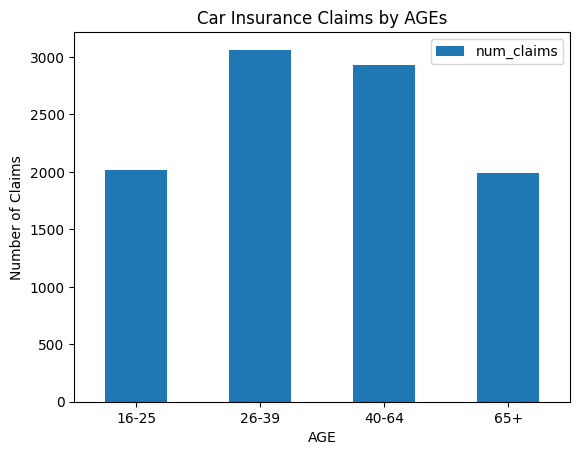

OUTCOME     0     1
AGE                
16-25     568  1448
26-39    2031  1032
40-64    2474   457
65+      1794   196


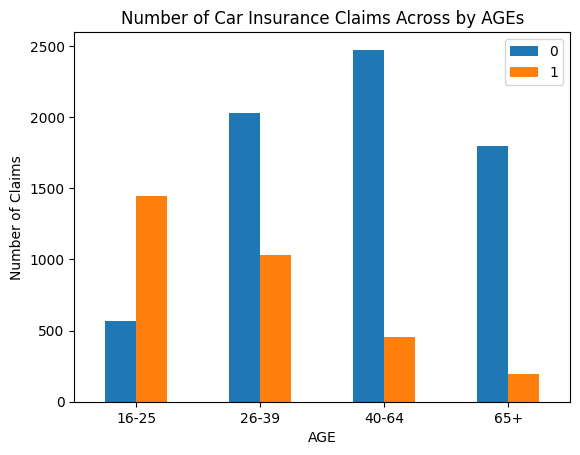

        num_claims
GENDER            
female        5010
male          4990


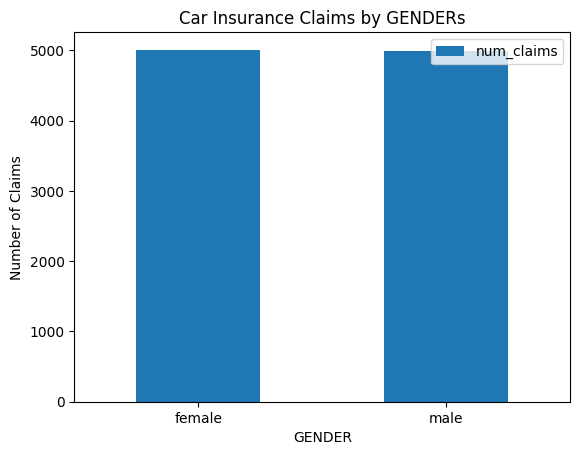

OUTCOME     0     1
GENDER             
female   3689  1321
male     3178  1812


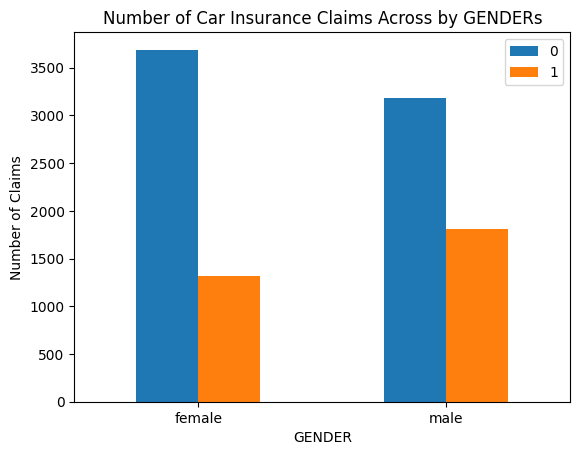

          num_claims
RACE                
majority        9012
minority         988


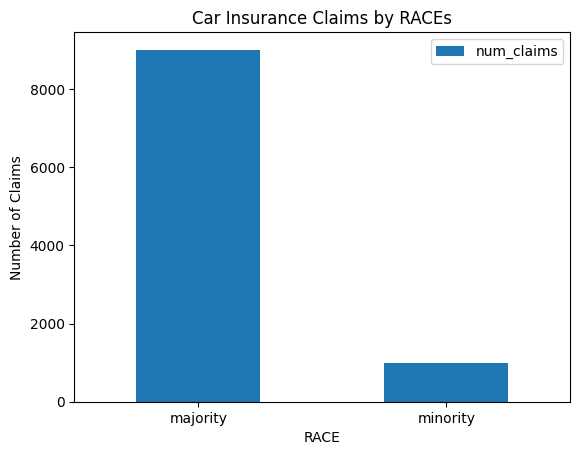

OUTCOME      0     1
RACE                
majority  6200  2812
minority   667   321


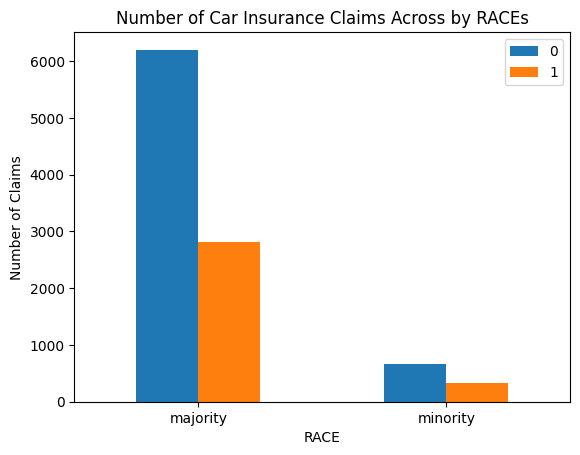

             num_claims
EDUCATION              
high school        4157
none               1915
university         3928


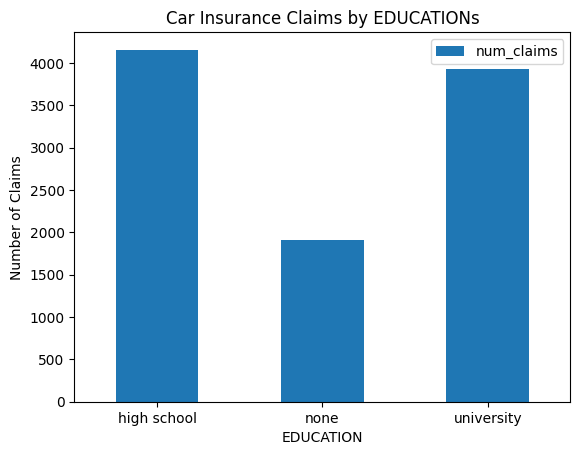

OUTCOME         0     1
EDUCATION              
high school  2813  1344
none         1012   903
university   3042   886


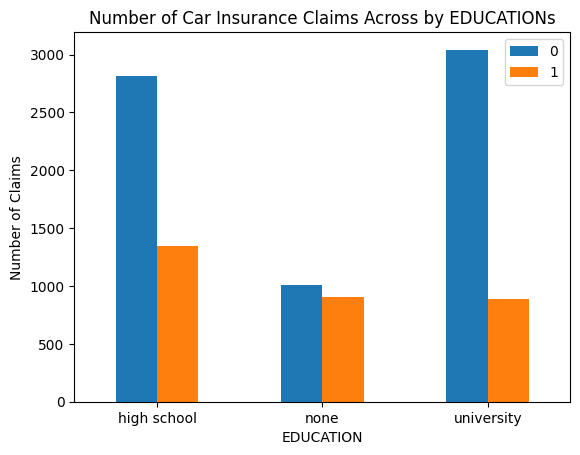

               num_claims
INCOME                   
middle class         2138
poverty              1814
upper class          4336
working class        1712


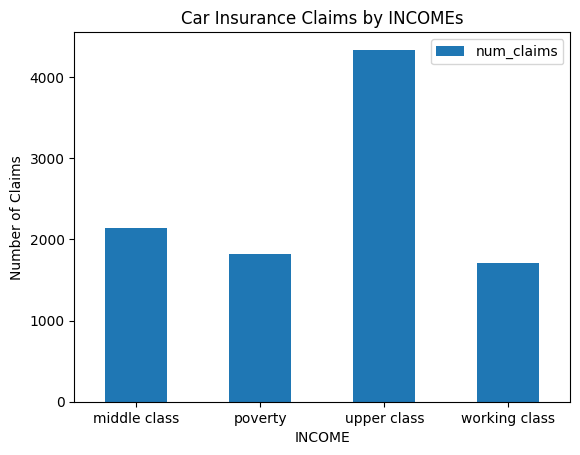

OUTCOME           0     1
INCOME                   
middle class   1546   592
poverty         628  1186
upper class    3757   579
working class   936   776


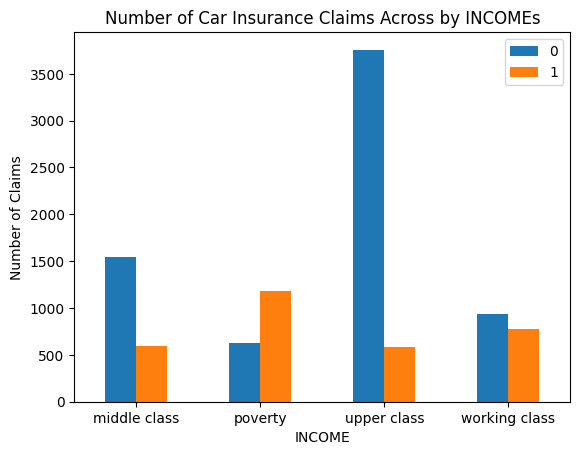

         num_claims
MARRIED            
0              5018
1              4982


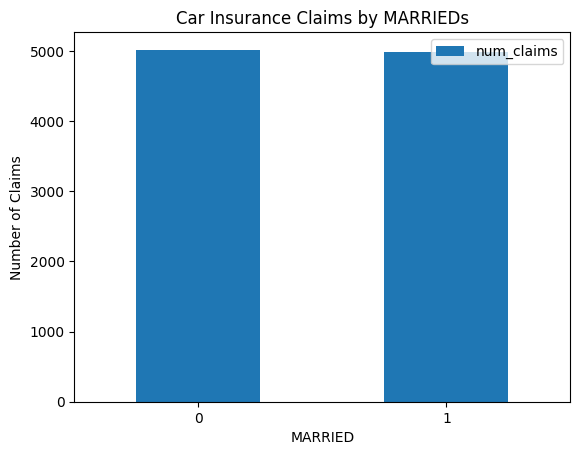

OUTCOME     0     1
MARRIED            
0        2838  2180
1        4029   953


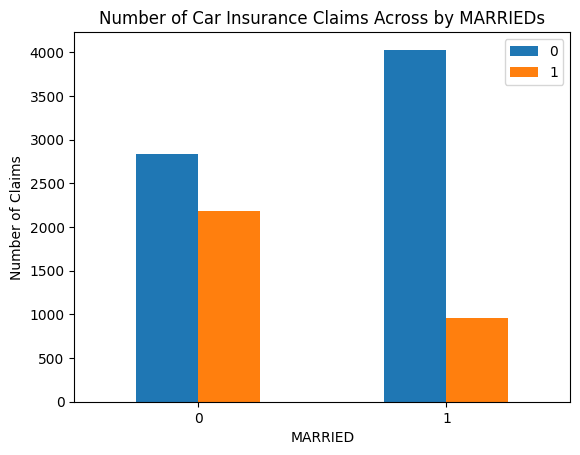

          num_claims
CHILDREN            
0               3112
1               6888


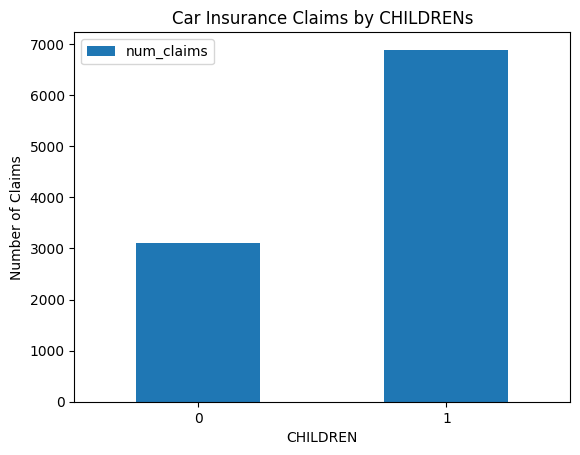

OUTCOME      0     1
CHILDREN            
0         1637  1475
1         5230  1658


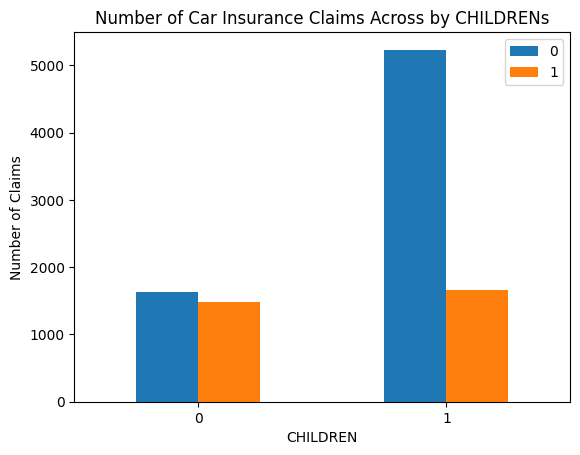

                   num_claims
VEHICLE_OWNERSHIP            
0                        3030
1                        6970


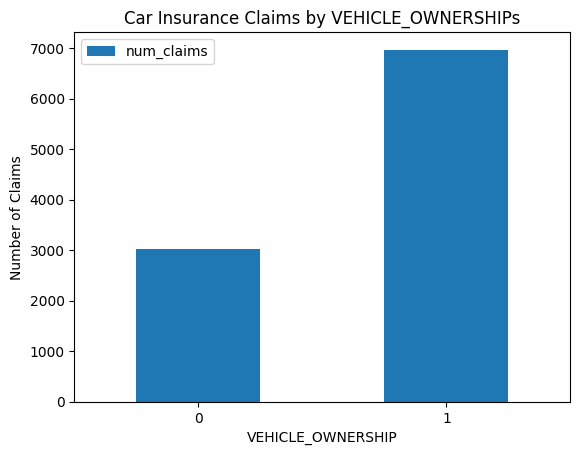

OUTCOME               0     1
VEHICLE_OWNERSHIP            
0                  1273  1757
1                  5594  1376


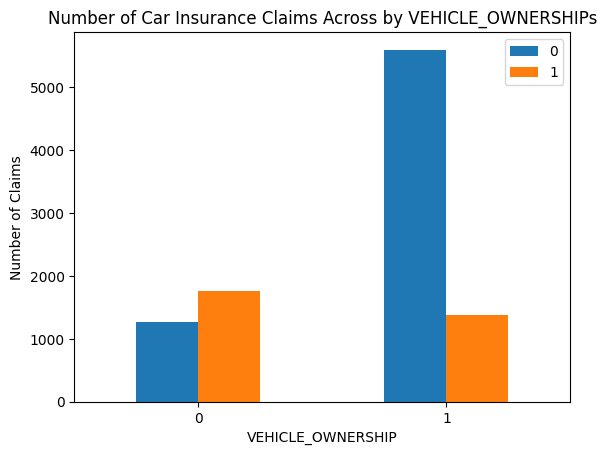

In [21]:
for item in demography:
    demography_claims_visualizer(item)

### Trends found in the data: Demography vs Number of Claims
- **Age**:
1. The ages 26-39 filed the highest number of car insurance claims, while the the age group 65+ filed the least number of car insurance claims.
2. The age group 16-25 has the highest number of paid insurance claims and the lowest number of unpaid insurance claims, while the age goup 40-64 has the highest number of unpaid insurance claims, and the age group 65+ has the lowest number of paid insurance claims.
3. The highest proportion of insurance claims was paid to the 16-25 age group, while the lowest proportion was paid to the 65+ age group.

- **Gender**:
4. There were slightly more females than males in the dataset, and females filed the higher number of car insurance claims.
5. Females had the highest number of unpaid insurance claims and the lowest proportion of paid insurance claims.

- **Race**:
6. The majority group filed highest number of car insurance claims and also received the highest number and proportion of paid claims.

- **Education**:
7. 'High school' holders filed the highest number of car insurance claims, while persons with no education ('none') filed the lowest number of insurance claims.
8. University graduates had the highest number of unpaid insurance claims and the lowest number and proportion of paid insurance claims, while high school holders had the highest number of paid claims, but persons with no education (none) had the highest proportion of paid claims.

- **Income**:
9. The 'upper class' filed the highest number of car insurance claims, while the working class filed the lowest number of claims, lower than that of people in the 'poverty' and 'middle class'.
10. Conversely, the 'upper class' received the lowest number and lowest proportion of paid claims, while the 'poverty' class had the highest number and proportion of paid claims.

- **Marriage**:
11. Unmarried persons filed slightly more car insurance claims than persons who are married.
12. Most of the claims (about 80%) filed by married people were unpaid, while most of the claims (about 88%) filed by unmarried people were paid.

- **Children**:
13. People who had children filed more claims than people without children.
14. Peolple who had children also have higher number of both paid and unpaid car insurance claims, while people without children had a higher proportion of paid car insurance claims.

- **Vehicle Ownership**:
15. People who owned a vehicle filed more car insurance claims than people who didn't own a vehicle.
16. People who owned a vehicle had a higher number of unpaid car insurance claims, while people who didn't own a vehicle had a higher number of paid insurance claims. This suggests that payment of insurance claims didn't necessarily depend on vehicle ownership.

#### B.
__Examine how insurance claims vary with driving experiences, and with respect to vehicle year and type.__

In [24]:
# Create a list for the above-mentioned factors
vehicle = ['DRIVING_EXPERIENCE', 'VEHICLE_YEAR', 'VEHICLE_TYPE']

In [25]:
def vehicle_claims_visualizer(factor):
    """Function takes an input related to vehicle, ownership or experience and gives
    dataframes and plots to visualize the dataframes as outputs."""

    df_factor = (df.groupby(factor)['OUTCOME'].count()
            .rename('num_claims')
            .to_frame()
                 )
    print(df_factor)

    df_factor.plot(kind='bar', xlabel=factor, ylabel='Number of Claims',
            title=f'Car Insurance Claims by {factor}s'
                  )
    plt.xticks(rotation=0)
    plt.savefig(f"image3_{factor}")
    plt.show()


    data = (df.groupby([factor, 'OUTCOME'])['OUTCOME'].count()
            .rename('num_claims')
            .to_frame()
            .reset_index()
          )

    # Pivot the resulting table for ease of visualization

    pivot_data = data.pivot(index=factor,
                                columns='OUTCOME', values='num_claims')
    print(pivot_data)

    # Plot bar chart to visualize result of grouped and pivoted data

    pivot_data.plot(kind='bar', stacked=False, xlabel=factor, ylabel='Number of Claims')
    plt.title(f'Number of Car Insurance Claims by {factor}s')
    plt.legend(loc='upper right')
    plt.xticks(rotation=0)
    plt.savefig(f"image4_{factor}")

    plt.show()


                    num_claims
DRIVING_EXPERIENCE            
0-9y                      3530
10-19y                    3299
20-29y                    2119
30y+                      1052


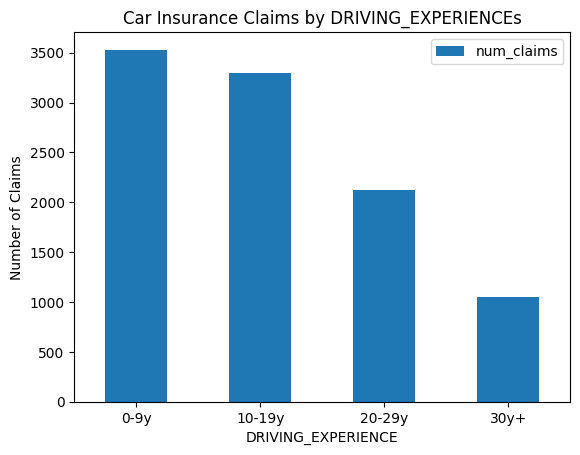

OUTCOME                0     1
DRIVING_EXPERIENCE            
0-9y                1313  2217
10-19y              2512   787
20-29y              2010   109
30y+                1032    20


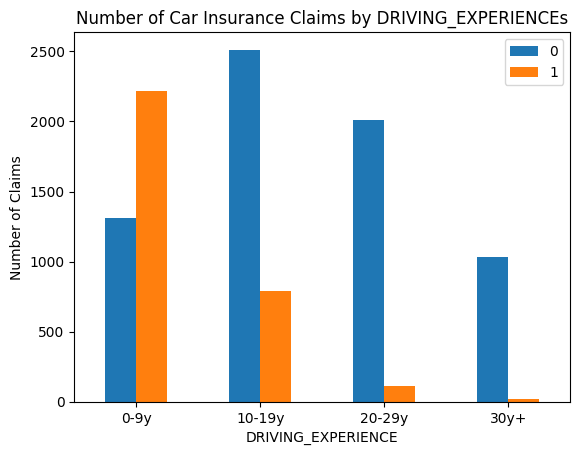

              num_claims
VEHICLE_YEAR            
after 2015          3033
before 2015         6967


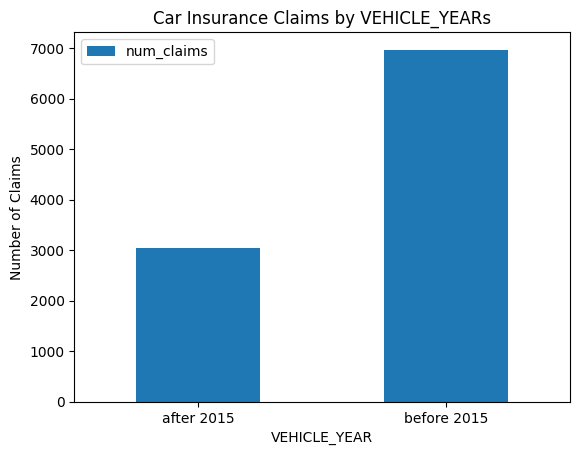

OUTCOME          0     1
VEHICLE_YEAR            
after 2015    2710   323
before 2015   4157  2810


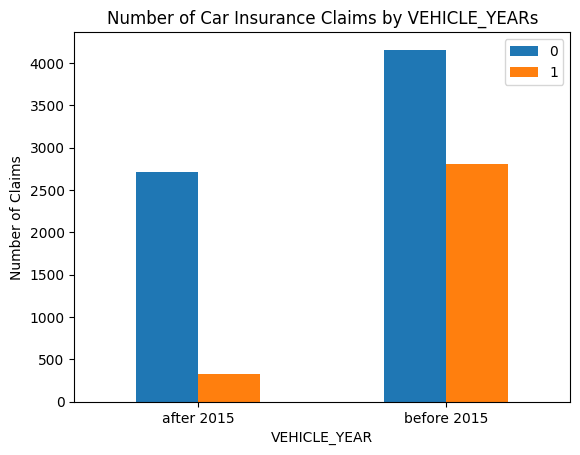

              num_claims
VEHICLE_TYPE            
sedan               9523
sports car           477


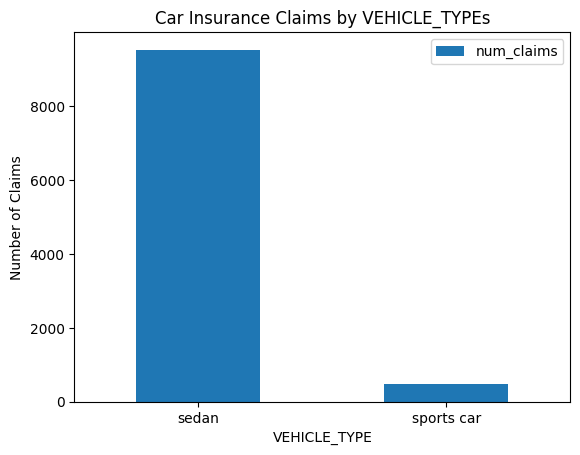

OUTCOME          0     1
VEHICLE_TYPE            
sedan         6545  2978
sports car     322   155


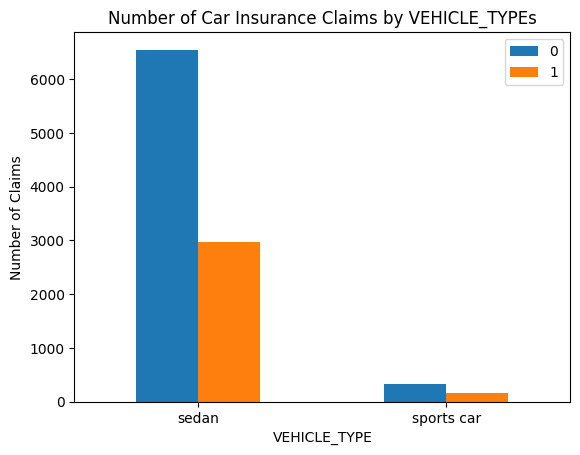

In [26]:
for item in vehicle:
    vehicle_claims_visualizer(item)

### Discussion of trends found in the data
- **Driving Experience**
1. People with 0-9y driving experience filed the highest number of insurance claims, followed by people with 10-19y
experience, then people with 20-29y experience, while people with 30y+ experience filed the least number of
claims.
2. Fortunately, people with 0-9y driving experience also had the highest number and proportion of paid claims,
while people with 10-19y driving experience had the highest number of unpaid claims.
3. People with the 30y+ driving experience had the lowest number of both paid and unpaid claims.

- **Vehicle Year**
4. Cars before 2015 had more insurance claims than cars after 2015 and also received more paid claims
than cars after 2015. This suggests that older cars are more likely to receive a paid car insurance
claim than newer cars.

- __Vehicle Type__
5. More car insurance claims were filed for Sedan cars than for sports cars.
6. While most of the claims filed for Sedan cars were unpaid, less than 50% of claims filed were paid.

### Step 3: Grouped Analysis

#### A. Demography and Driving Behaviours/ Histories
Examine how driving behaviours/ histories such as speeding violations, DUIs, annual mileage and past accidents
possibly determine number of car insurance claims filed and paid/received.

In [27]:
driving = ['SPEEDING_VIOLATIONS', 'DUIS', 'ANNUAL_MILEAGE', 'PAST_ACCIDENTS']

#### I. Group speeding violations by each demographic factor and inspect outcome of associated car insurance claims

       Avg_Speeding_Violations
AGE                           
16-25                 0.000000
26-39                 1.009468
40-64                 1.937564
65+                   3.044221 

OUTCOME         0         1
AGE                        
16-25    0.000000  0.000000
26-39    1.055145  0.919574
40-64    2.121261  0.943107
65+      3.248049  1.178571 

        Avg_Speeding_Violations
GENDER                         
female                 1.030739
male                   1.936874 

OUTCOME         0         1
GENDER                     
female   1.291949  0.301287
male     2.659534  0.669426 

          Avg_Speeding_Violations
RACE                             
majority                 1.493342
minority                 1.387652 

OUTCOME          0         1
RACE                        
majority  1.935323  0.518848
minority  1.827586  0.473520 

             Avg_Speeding_Violations
EDUCATION                           
high school                 1.406062
none                        0.9

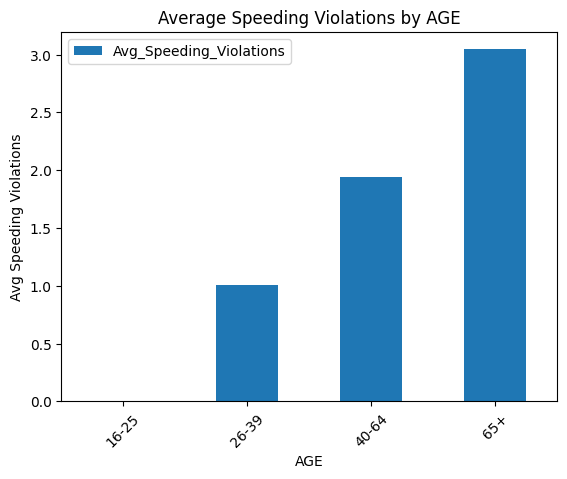

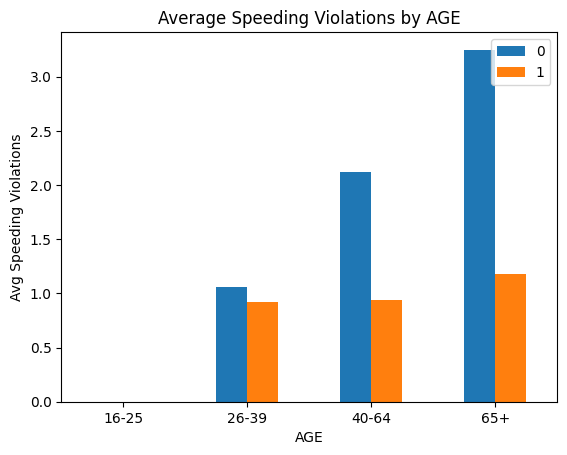

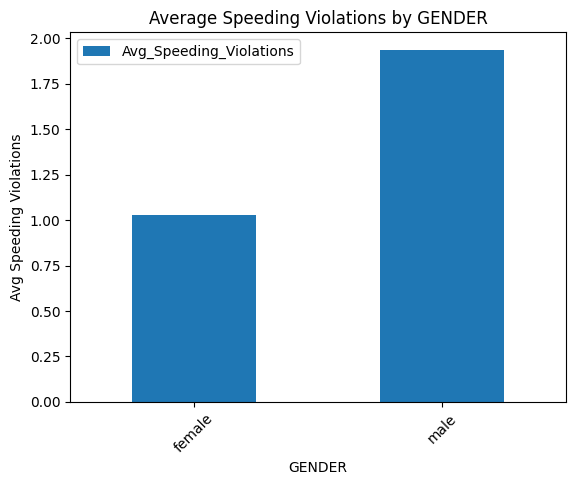

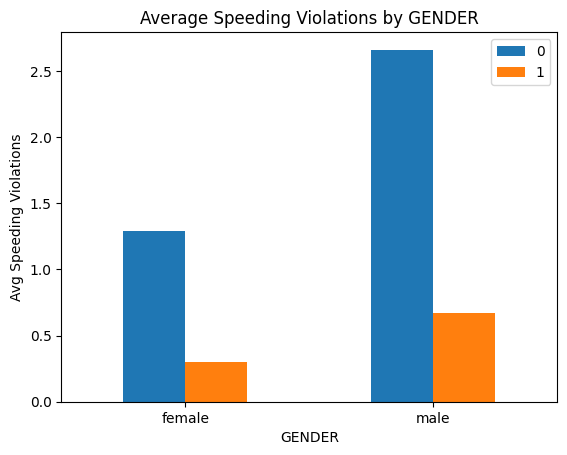

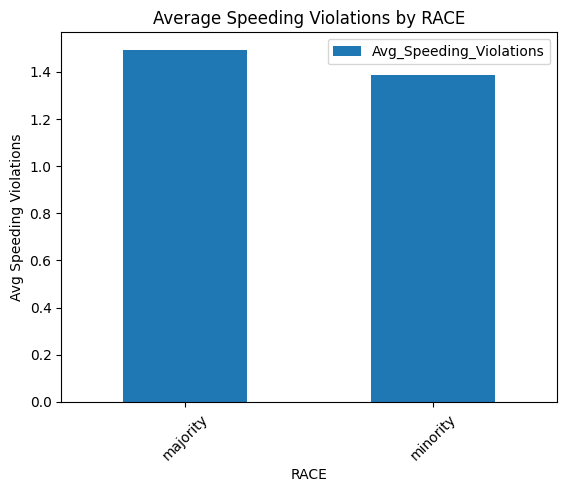

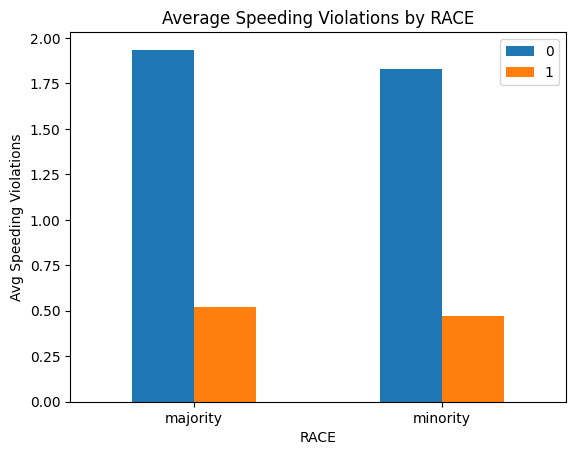

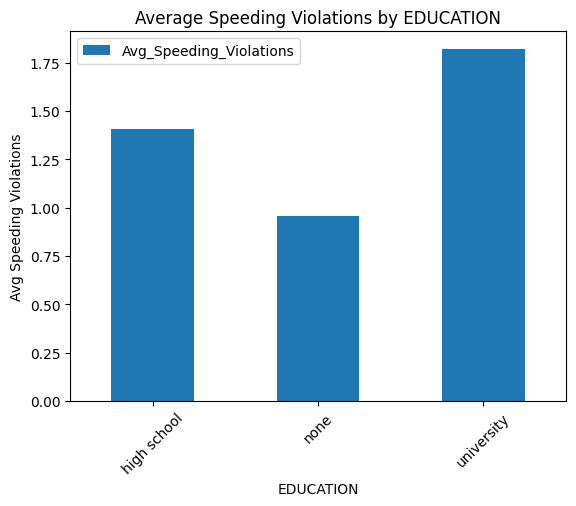

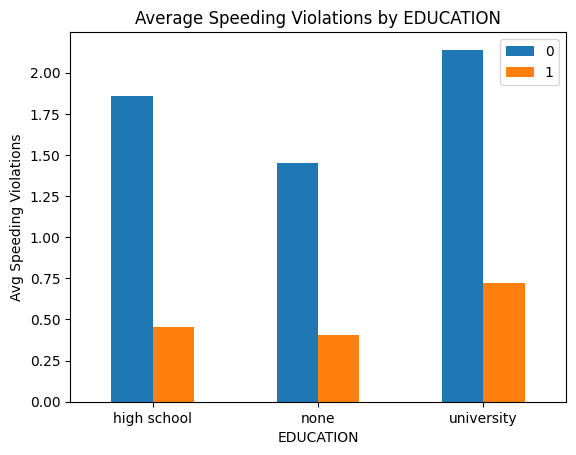

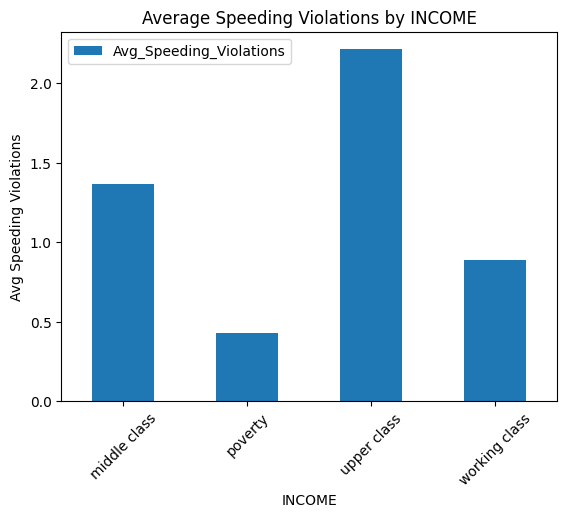

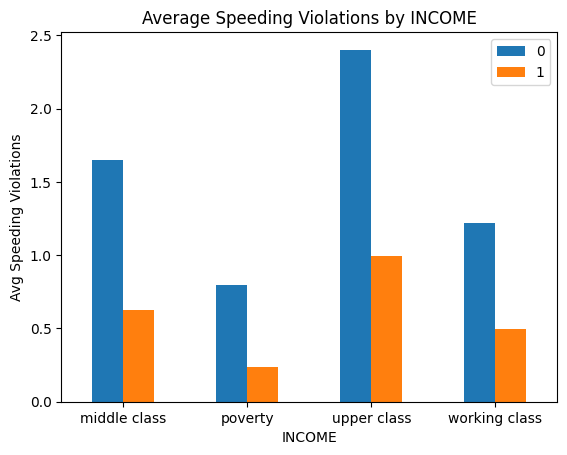

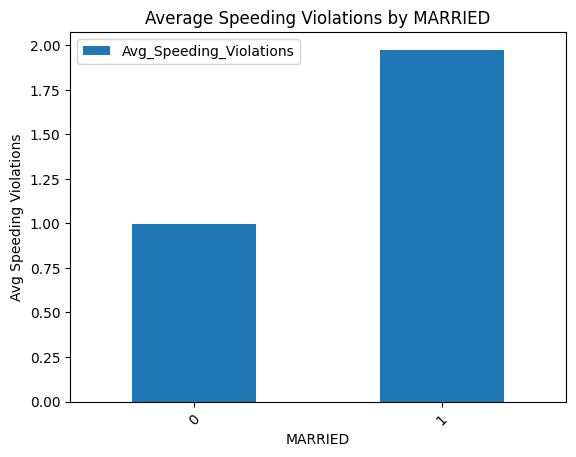

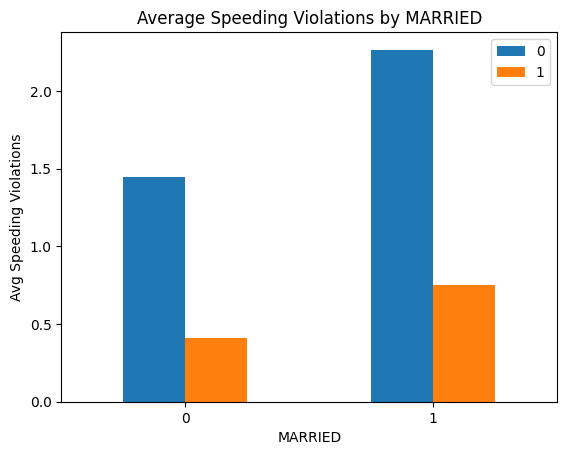

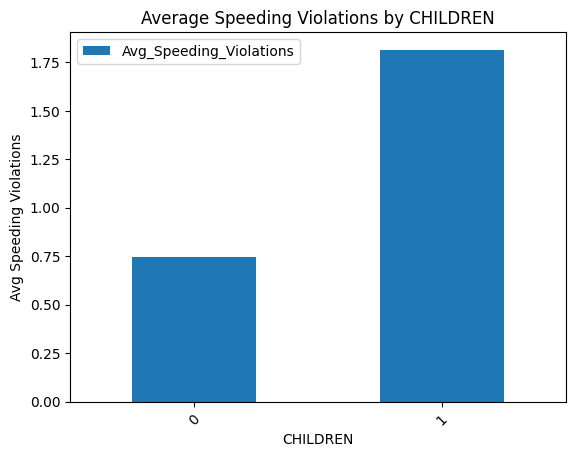

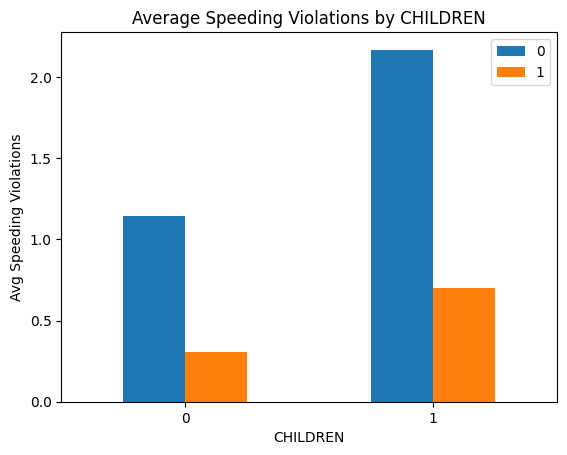

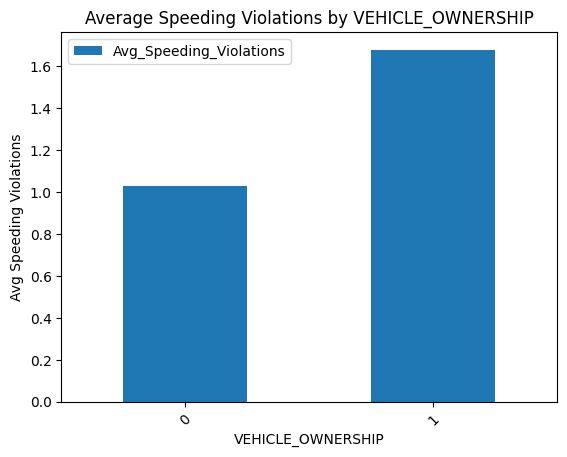

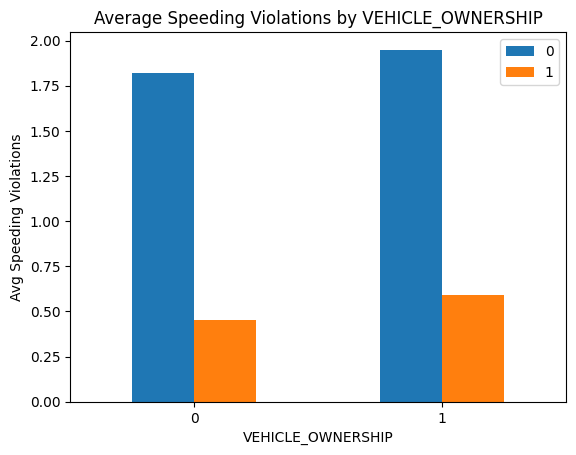

In [28]:
for item in demography:
    # Group speeding violations by each demographic factor
    t = (df.groupby([item])['SPEEDING_VIOLATIONS'].mean().rename('Avg_Speeding_Violations').to_frame())

    # Group speeding violations by each demographic factor and by OUTCOME of insurance claims
    t_ = (df.groupby([item, 'OUTCOME'])['SPEEDING_VIOLATIONS'].mean()
          .rename('Avg_Speeding_Violations')
          .to_frame()
          .reset_index())

    # Pivot the resulting table for ease of visualization
    pivot_t_= t_.pivot(index=item,
                                columns='OUTCOME', values='Avg_Speeding_Violations')

    print(t, '\n')

    # Plot bar chart of demography by speed violations
    t.plot(kind='bar', xlabel=item, ylabel='Avg Speeding Violations',
          title=f'Average Speeding Violations by {item}')
    plt.xticks(rotation=45)

    print(pivot_t_, '\n')

    # Plot bar chart to visualize result of grouped and pivoted data
    pivot_t_.plot(kind='bar', stacked=False, xlabel=item, ylabel='Avg Speeding Violations')
    plt.title(f'Average Speeding Violations by {item}')
    plt.legend(loc='upper right')
    plt.xticks(rotation=0)

#### Insights
*Age*
- Most speeding violations were committed by persons in the 65+ age group.
- There was no record of speeding violations among people in the 16-25 age group.
- Across the 3 age groups where speeding violations occurred, the higher speeding violation figures within an age group, lesser the number of paid claims received.

*Gender*
Males have a higher record of speeding violations than females.

*Race*
Although the majority race had more incidents of speeding violations, the record for the minority race is only slightly lower.



#### II. Group DUIS by each demographic factor and inspect outcome of associated car insurance claims

       Avg_DUIS
AGE            
16-25  0.000000
26-39  0.172706
40-64  0.324463
65+    0.458291 

OUTCOME         0         1
AGE                        
16-25    0.000000  0.000000
26-39    0.185623  0.147287
40-64    0.353678  0.166302
65+      0.489409  0.173469 

        Avg_DUIS
GENDER          
female  0.187026
male    0.291583 

OUTCOME         0         1
GENDER                     
female   0.232854  0.059046
male     0.399937  0.101545 

          Avg_DUIS
RACE              
majority  0.242011
minority  0.213563 

OUTCOME          0         1
RACE                        
majority  0.312419  0.086771
minority  0.289355  0.056075 

             Avg_DUIS
EDUCATION            
high school  0.223478
none         0.160836
university   0.294043 

OUTCOME             0         1
EDUCATION                      
high school  0.297903  0.067708
none         0.248024  0.063123
university   0.342209  0.128668 

               Avg_DUIS
INCOME                 
middle class   0.215154
povert

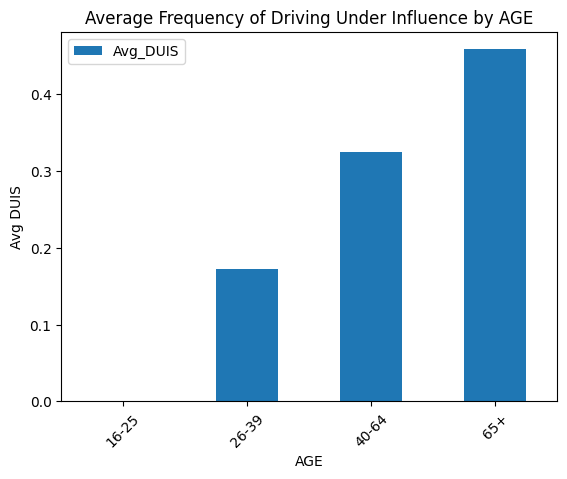

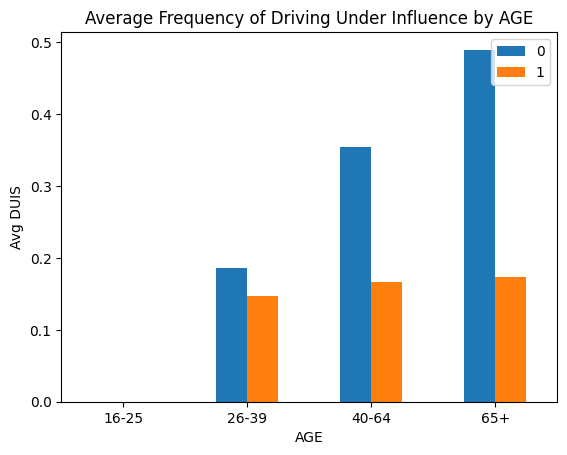

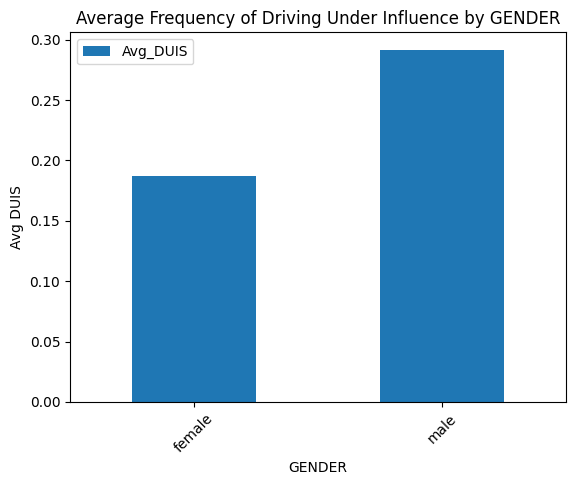

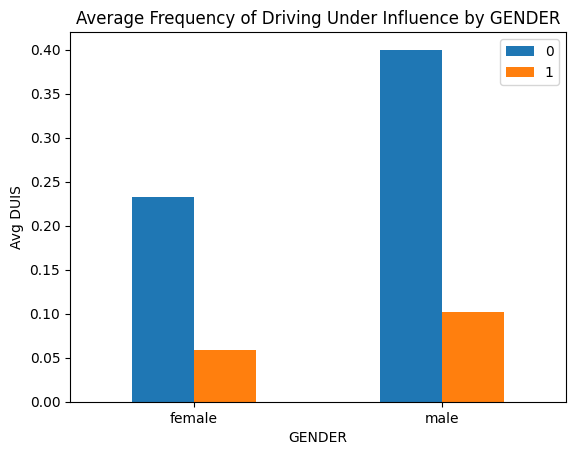

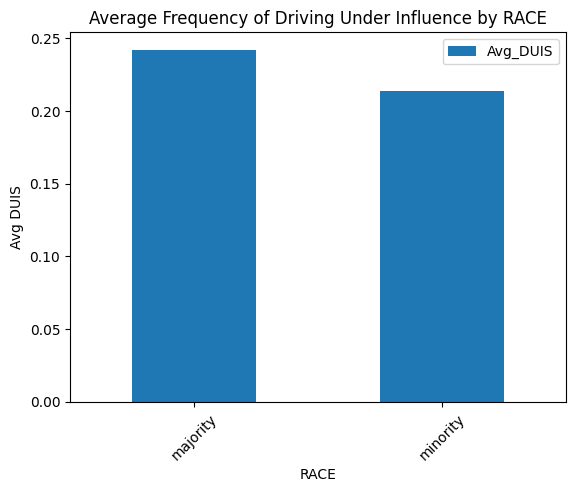

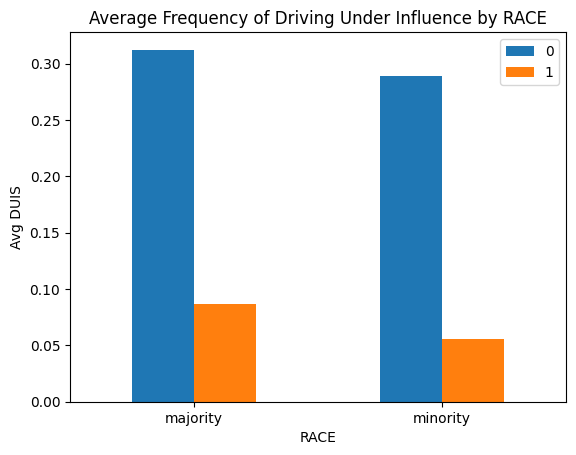

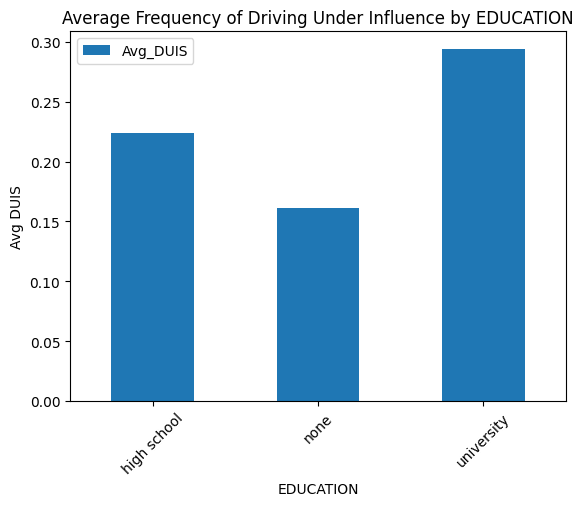

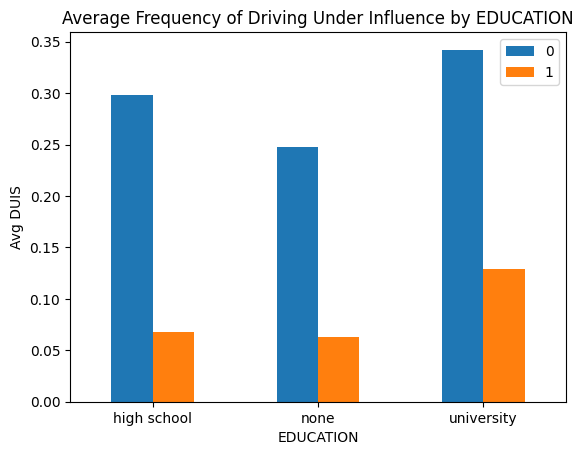

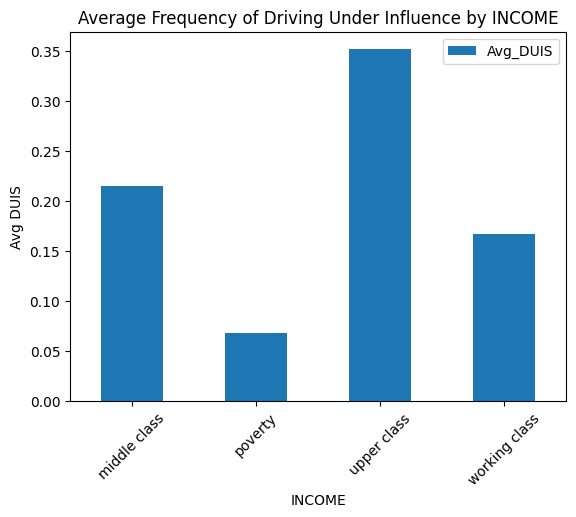

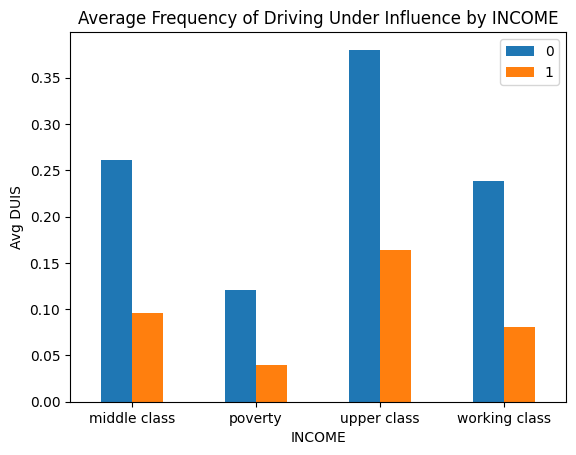

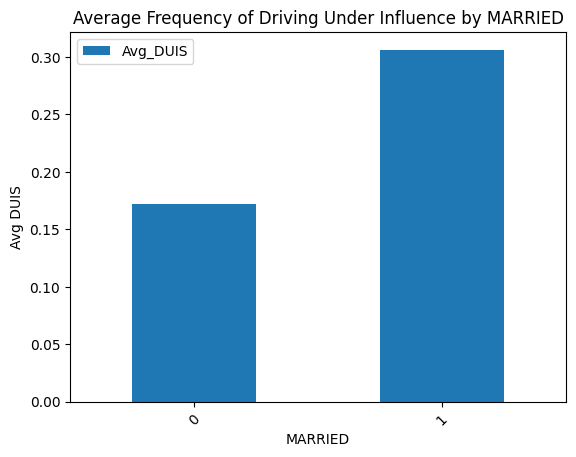

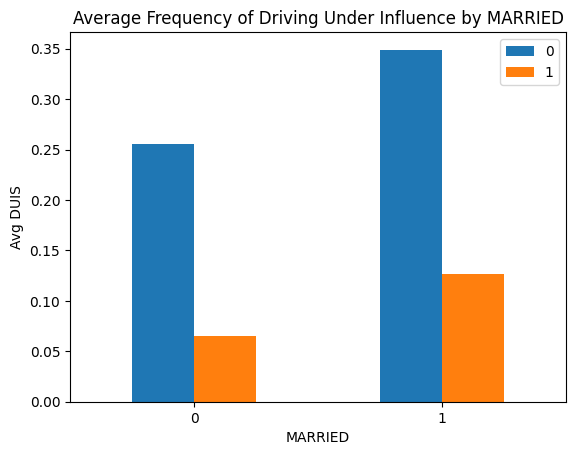

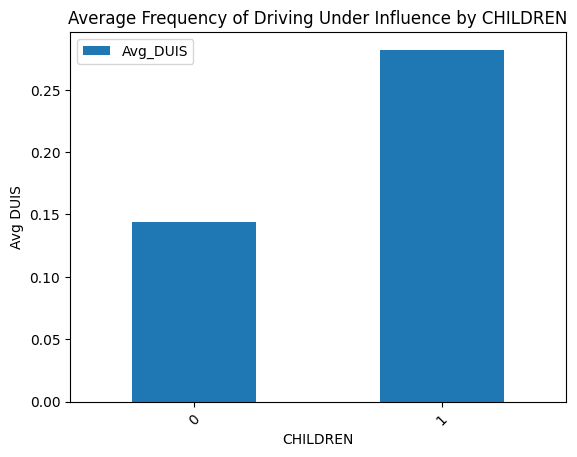

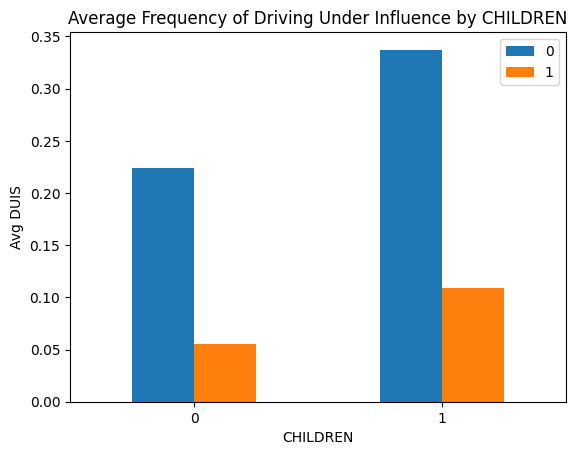

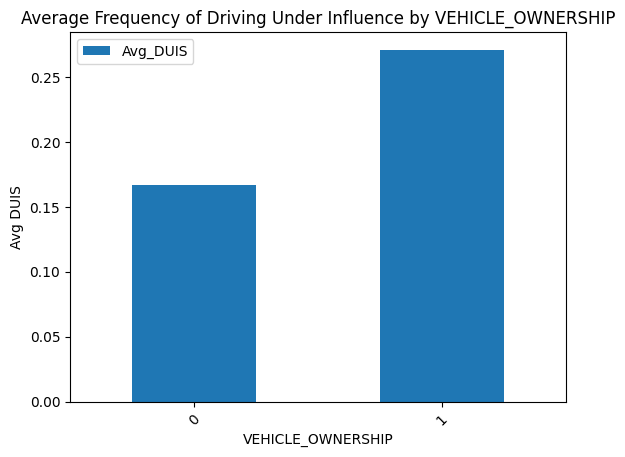

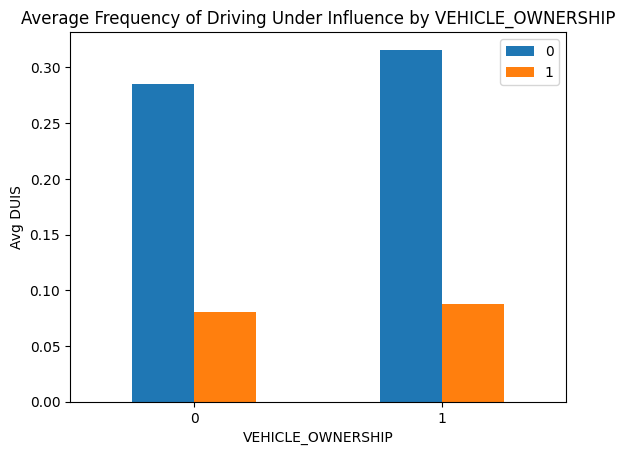

In [29]:
for item in demography:
    # Group DUIS by each demographic factor
    t = (df.groupby([item])['DUIS'].mean().rename('Avg_DUIS').to_frame())

    # Group DUIS by each demographic factor and by OUTCOME of insurance claims
    t_ = (df.groupby([item, 'OUTCOME'])['DUIS'].mean()
          .rename('Avg_DUIS')
          .to_frame()
          .reset_index())

    # Pivot the resulting table for ease of visualization
    pivot_t_= t_.pivot(index=item,
                                columns='OUTCOME', values='Avg_DUIS')

    print(t, '\n')

    # Plot bar chart of demography by DUIS
    t.plot(kind='bar', xlabel=item, ylabel='Avg DUIS',
          title=f'Average Frequency of Driving Under Influence by {item}')
    plt.xticks(rotation=45)

    print(pivot_t_, '\n')

    # Plot bar chart to visualize result of grouped and pivoted data
    pivot_t_.plot(kind='bar', stacked=False, xlabel=item, ylabel='Avg DUIS')
    plt.title(f'Average Frequency of Driving Under Influence by {item}')
    plt.legend(loc='upper right')
    plt.xticks(rotation=0)